## BBC Text MultiClass Classification - BERT: Bidirectional Encoder Representations from Transformers

BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1

[![BERT](Screenshot-from-2019-06-18-08-46-42.png)](https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1)

[![BERT](Screenshot-from-2019-06-18-08-45-09.png)](https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1)

### Get BERT server and client

#### server

```bash
$ pip install bert-serving-server  
```
#### client, independent of bert-serving-server`

```bash
$ pip install bert-serving-client 
```

#### download BERT
```bash
$ wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip && unzip uncased_L-12_H-768_A-12.zip
```

#### Run BERT Server
```bash
$ bert-serving-start -model_dir uncased_L-12_H-768_A-12/ -num_worker=2 -max_seq_len 50
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import model_selection, preprocessing
import re
import spacy
from nltk.stem import WordNetLemmatizer  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import  Reshape,Input,Embedding, Lambda,Dropout,Conv1D,Conv2D,Activation, Dense, Bidirectional,GlobalMaxPooling1D, LSTM, SpatialDropout1D, TimeDistributed,Masking,Layer
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import MaxPool1D
import tensorflow.keras.backend as K

/home/syava/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/syava/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/syava/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/syava/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: Futu

In [2]:
# load the dataset
trainDF = pd.read_csv('bbc-text.csv') # encoding = "latin"

In [3]:
trainDF.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [4]:
trainDF.shape

(2225, 2)

In [5]:
trainDF['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [6]:
trainDF['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

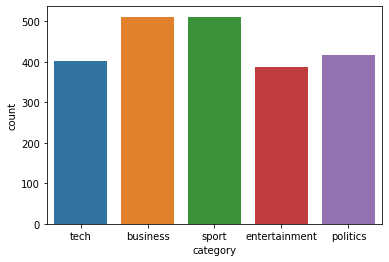

In [7]:
sns.countplot(trainDF['category'])

In [8]:
# clean text from noise
def clean_text(text):
    
    # remove next lines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    
    # filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    # remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # convert to lowercase to maintain consistency
    text = text.lower()
    
    # tokenize words
    # tokens = word_tokenize(text)
    
    # lemmatization of words
    # lemmatizer = WordNetLemmatizer()
    
    # lemmas = []
    # for tok in tokens:
    #    lemmas.append(lemmatizer.lemmatize(tok.lower()))
    
    # get unique words
    # tokens = list(set(lemmas))
    
    # STOPLIST = set(stopwords.words('english'))
    # SYMBOLS = " ".join(string.punctuation).split(" ")
    # reomve stop words and special charaters
    # tokens = [tok for tok in tokens if tok not in STOPLIST]
    # tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    # tokens = [tok for tok in tokens if len(tok) >= 3]
    
    # remove remaining tokens that are not alphabetic
    # tokens = [tok for tok in tokens if tok.isalpha()]
    
    # stemming of words
    # porter = PorterStemmer()
    # tokens = [porter.stem(word) for word in tokens]
        
    return text

## Data preparation

In [9]:
# Data cleaning
trainDF['text'] = trainDF['text'].apply(lambda x:clean_text(x))
# Label Encoding
le = preprocessing.LabelEncoder()
le.fit(trainDF['category'])

def encode(le, labels):
    enc = le.transform(labels)
    return tf.keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)


X = trainDF['text']
y = encode(le, trainDF['category'])

In [10]:
# split the dataset into training and validation datasets
x_train, x_val, y_train, y_val = model_selection.train_test_split(np.asarray(X), np.asarray(y), test_size=0.2, random_state=42)

In [11]:
x_train.shape,y_train.shape, x_val.shape,y_val.shape

((1780,), (1780, 5), (445,), (445, 5))

## Model Building

In [12]:
from bert_serving.client import BertClient

# make a connection with the BERT server using it's ip address
bc = BertClient(ip="YOUR_SERVER_IP")
# get the embedding for train and val sets
X_tr_bert = bc.encode(x_train.tolist())
X_val_bert = bc.encode(x_val.tolist())

/home/syava/.local/lib/python3.6/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=50" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


In [13]:
print('Build model...')
model = Sequential()
model.add(Reshape((768,1),input_shape=(768,)))
model.add(Dense(64, input_shape=(768,1),activation="relu"))
model.add(Dropout(0.2))
model.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))
model.add(MaxPool1D(pool_size = 2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(5, activation = 'softmax'))             
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 768, 1)            0         
_________________________________________________________________
dense (Dense)                (None, 768, 64)           128       
_________________________________________________________________
dropout (Dropout)            (None, 768, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 766, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 383, 64)           0         
_________________________________________________________________
lstm (

In [14]:
print('Train...')
# checkpoint
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
stoperly = EarlyStopping(monitor="val_loss",mode="auto",verbose=1)
callbacks_list = [checkpoint]
history = model.fit(X_tr_bert, y_train,batch_size=64,epochs=50,validation_data=(X_val_bert, y_val),callbacks=callbacks_list)

Train...
Train on 1780 samples, validate on 445 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1728/1780 [============================>.] - ETA: 0s - loss: 1.6002 - acc: 0.2373
Epoch 00001: val_acc improved from -inf to 0.27191, saving model to ./model.h5
1780/1780 [==============================] - 19s 11ms/sample - loss: 1.6000 - acc: 0.2365 - val_loss: 1.5890 - val_acc: 0.2719
Epoch 2/50
1728/1780 [============================>.] - ETA: 0s - loss: 1.5604 - acc: 0.3113
Epoch 00002: val_acc improved from 0.27191 to 0.36404, saving model to ./model.h5
1780/1780 [==============================] - 18s 10ms/sample - loss: 1.5601 - acc: 0.3096 - val_loss: 1.4986 - val_acc: 0.3640
Epoch 3/50
1728/1780 [============================>.] - ETA: 0s - loss: 1.3774 - acc: 0.4323
Epoch 00003: val_acc improved from 0.36404 to 0.47191, saving model to ./model.h5
1780/1780 [==============================] - 18s 10ms/sample - loss: 1.3756 - acc: 0.4326 - val_loss: 1.2983 - val_acc: 

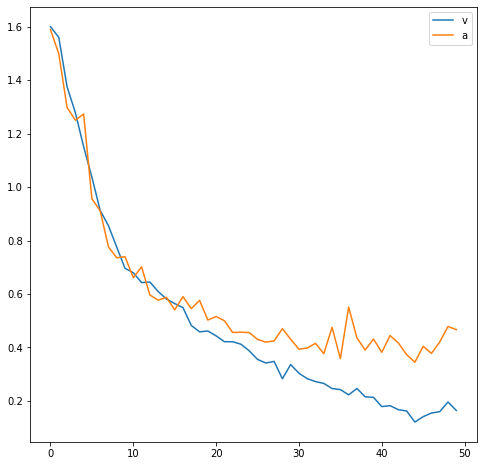

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(history.history["loss"])
ax.legend("loss")
ax.plot(history.history["val_loss"])
ax.legend("val_loss")

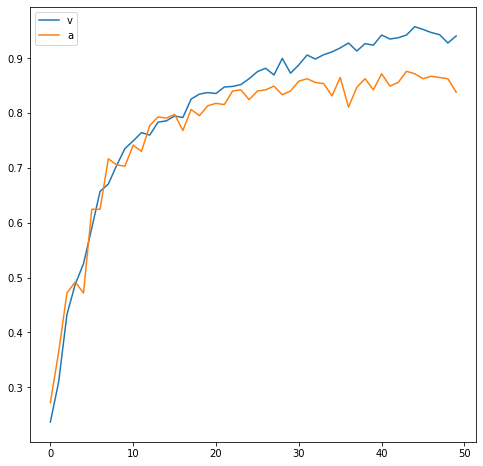

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(history.history["acc"])
ax.legend("acc")
ax.plot(history.history["val_acc"])
ax.legend("val_acc")